In [75]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

**毒入毒品建模資料集，利用 `value_counts()` 計算出非再犯與再犯的資料數量，並使用 `train_test_split()` 將資料集分為訓練子集與測試子集，其中測試資料集的數量為總數的20%**

In [76]:
df = pd.read_csv("../data/trainDRUG.csv")

In [77]:
df['再犯註記'].value_counts()

0    53906
1    11496
Name: 再犯註記, dtype: int64

In [78]:
X = df.drop(['再犯註記'], axis=1)
y = df['再犯註記']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, stratify=y)

In [80]:
y_train.value_counts()

0    43124
1     9197
Name: 再犯註記, dtype: int64

In [81]:
y_test.value_counts()

0    10782
1     2299
Name: 再犯註記, dtype: int64

In [82]:
target_names = ['未再犯','再犯']
aucs = []

### model1: 基本模型/原始資料

資料分布不變動，以隨機森林模型預設值建模驗證

In [83]:
model1 = RandomForestClassifier(random_state=42, n_jobs=-1)
model1.fit(X_train, y_train)
y_predproba = model1.predict_proba(X_test)[:, 1]
y_pred = model1.predict(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_predproba)
auc1 = roc_auc_score(y_test, y_predproba)
aucs.append(auc1)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.96      0.91     10782
          再犯       0.59      0.26      0.36      2299

    accuracy                           0.84     13081
   macro avg       0.72      0.61      0.63     13081
weighted avg       0.81      0.84      0.81     13081



### model2: RF with balanced weight

資料分布不變動，以全體權重為基礎，建立預設值的隨機森林模型建模驗證

In [84]:
model2 = RandomForestClassifier(class_weight='balanced',random_state=42, n_jobs=-1)
model2.fit(X_train, y_train)
y_predproba = model2.predict_proba(X_test)[:, 1]
y_pred = model2.predict(X_test)
fpr2, tpr2, _ = roc_curve(y_test, y_predproba)
auc2 = roc_auc_score(y_test, y_predproba)
aucs.append(auc2)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.95      0.90     10782
          再犯       0.55      0.26      0.35      2299

    accuracy                           0.83     13081
   macro avg       0.70      0.61      0.63     13081
weighted avg       0.80      0.83      0.81     13081



### model3: RF with balanced_subsample weight

資料分布不變動，以每次執行時權重為基礎，建立預設值的隨機森林模型建模驗證

In [85]:
model3 = RandomForestClassifier(class_weight='balanced_subsample',random_state=42, n_jobs=-1)
model3.fit(X_train, y_train)
y_predproba = model3.predict_proba(X_test)[:, 1]
y_pred = model3.predict(X_test)
fpr3, tpr3, _ = roc_curve(y_test, y_predproba)
auc3 = roc_auc_score(y_test, y_predproba)
aucs.append(auc3)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.86      0.96      0.90     10782
          再犯       0.56      0.26      0.35      2299

    accuracy                           0.83     13081
   macro avg       0.71      0.61      0.63     13081
weighted avg       0.81      0.83      0.81     13081



### model4: RF with SMOTE (oversampling)

運用 SMOTE 上採樣方法，將訓練集的再犯的數量擴增至與非再犯數量一致，建立預設值的隨機森林模型建模驗證

In [86]:
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train) #X, y
model4 = RandomForestClassifier(random_state=42, n_jobs=-1)
model4.fit(X_over, y_over)
y_predproba = model4.predict_proba(X_test)[:, 1]
y_pred = model4.predict(X_test)
fpr4, tpr4, _ = roc_curve(y_test, y_predproba)
auc4 = roc_auc_score(y_test, y_predproba)
aucs.append(auc4)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         未再犯       0.88      0.85      0.86     10782
          再犯       0.39      0.45      0.42      2299

    accuracy                           0.78     13081
   macro avg       0.63      0.65      0.64     13081
weighted avg       0.79      0.78      0.79     13081



### model5: pipleline process for undersampling + SMOTE

In [87]:
u = RandomUnderSampler(random_state=42, sampling_strategy={0:30000})
o = SMOTE()
m = RandomForestClassifier(random_state=42)

In [88]:
# pipeline 設定
pipeline = Pipeline([
    ('undersampler', u),
    ('oversampler', o),
    ('model', m)
])

In [89]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy={0: 30000})),
                ('oversampler', SMOTE()),
                ('model', RandomForestClassifier(random_state=42))])

In [90]:
prediction = pipeline.predict(X_test)

In [91]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     10782
           1       0.37      0.50      0.43      2299

    accuracy                           0.77     13081
   macro avg       0.63      0.66      0.64     13081
weighted avg       0.80      0.77      0.78     13081



### 人為定義採樣策略

In [92]:
# 定義下採樣策略
u_strategy = [
    {0:50000},
    {0:40000},
    {0:30000},
    {0:20000},
    {0:10000},
    {0:5000}
]

In [93]:
# 定義上採樣策略
o_strategy = [
    {1:50000},
    {1:40000},
    {1:30000},
    {1:20000},
    {1:10000},
    {1:5000}
]

In [94]:
hp_pipeline = Pipeline([
    ('undersampler', u),
    ('oversampler',o),
    ('model',m)
])

In [95]:
grid_params = {
    'undersampler__sampling_strategy': u_strategy,
    'oversampler__sampling_strategy': o_strategy
}

In [96]:
clf = GridSearchCV(estimator = hp_pipeline, param_grid = grid_params)

In [97]:
%%capture
clf.fit(X_train, y_train)

In [98]:
clf.best_params_

{'oversampler__sampling_strategy': {1: 10000},
 'undersampler__sampling_strategy': {0: 30000}}

In [99]:
pipeline_best_model = clf.best_estimator_

In [100]:
pipeline_best_model.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy={0: 30000})),
                ('oversampler', SMOTE(sampling_strategy={1: 10000})),
                ('model', RandomForestClassifier(random_state=42))])

In [101]:
y_pred = pipeline_best_model.predict(X_test)

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10782
           1       0.51      0.33      0.40      2299

    accuracy                           0.83     13081
   macro avg       0.69      0.63      0.65     13081
weighted avg       0.81      0.83      0.81     13081



In [103]:
#y_pred_proba[:1] 再犯的機率 
y_pred_proba = pipeline_best_model.predict_proba(X_test)[:,1]

In [104]:
fpr5, tpr5, _ = roc_curve(y_test, y_pred_proba)
auc5 = roc_auc_score(y_test, y_pred_proba)
aucs.append(auc5)

`sklearn.metrics.roc_curve()` Compute Receiver operating characteristic (ROC), restricted to the binary classification task.
y_true, True binary labels. If labels are not either {-1, 1} or {0, 1}, then pos_label should be explicitly given. 
y_score, Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions.
fpr is Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].
tpr is Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].

### 建立ROC_AUC圖

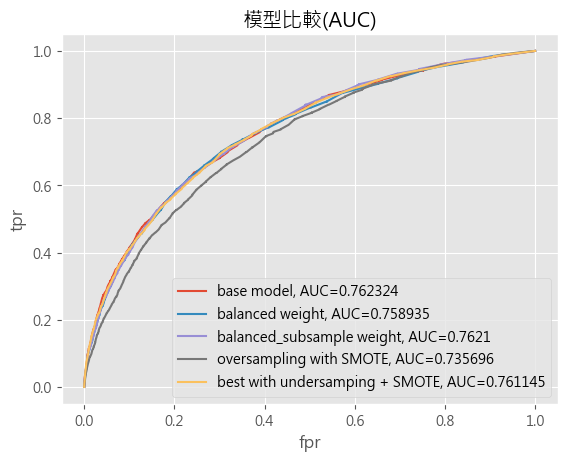

In [105]:
# plot ROC_AUC graph
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr1,tpr1,label="base model, AUC="+str(round(auc1,6)))
plt.plot(fpr2,tpr2,label="balanced weight, AUC="+str(round(auc2,6)))
plt.plot(fpr3,tpr3,label="balanced_subsample weight, AUC="+str(round(auc3,6)))
plt.plot(fpr4,tpr4,label="oversampling with SMOTE, AUC="+str(round(auc4,6)))
plt.plot(fpr5,tpr5,label="best with undersamping + SMOTE, AUC="+str(round(auc5,6)))

plt.legend(loc=0)
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.savefig("modelAUCs.png")

### 建立結果資料表

In [106]:
results = pd.DataFrame(columns=['模型','AUC','準確率','精確率', '招回率','f1_score', '非再犯案例數','精確率', '招回率','f1_score', '再犯案例數'])

In [107]:
models = [model1, model2, model3, model4, pipeline_best_model]
modelName = ['RF+原始資料','RF+balanced weight', 'RF+balanced subsample', 'RF+SMOTE', 'RF+u/o']
k=1
for m in models:
    predict_y = m.predict(X_test)
    acc = accuracy_score(y_test, predict_y)
    prf = precision_recall_fscore_support(y_test, predict_y)
    data = [modelName[k-1], aucs[k-1], acc]
    for item in prf:
        data.append(item[0])
    for item2 in prf:
        data.append(item2[1])
    results.loc[len(results)]=data
    k=k+1

    

In [108]:
results.to_excel("output.xlsx")
#results

In [109]:
results

,模型,AUC,準確率,精確率,招回率,f1_score,非再犯案例數,精確率,招回率,f1_score,再犯案例數
0,RF+原始資料,0.762324,0.837474,0.858456,0.961324,0.906983,10782,0.585899,0.256633,0.356927,2299
1,RF+balanced weight,0.758935,0.832352,0.858203,0.954276,0.903693,10782,0.548535,0.260548,0.353288,2299
2,RF+balanced subsample,0.762100,0.834034,0.858284,0.956594,0.904777,10782,0.560150,0.259243,0.354445,2299
3,RF+SMOTE,0.735696,0.778763,0.879012,0.848358,0.863413,10782,0.388785,0.452371,0.418175,2299
4,RF+u/o,0.761145,0.826772,0.867766,0.931831,0.898658,10782,0.510978,0.334058,0.403998,2299
